Importing Packages

In [102]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from google.colab import files

Plotting Setups

In [ ]:
fontsize= 14
ticksize = 14
figsize = (12, 4.5)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

Setting Up the model Parameters

In [ ]:
class Params:
    def __init__(self,
                 alpha = 0.33,
                 beta = 0.97,
                 delta = 0.1,
                 psi   = 1.0,
                 k_0 = 3,
                ):
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.psi = psi
        self.k_0 = k_0

Functions

In [ ]:
def f(k,l):
    alpha = Params().alpha
    return (k**alpha)*(l)**(1-alpha)

In [ ]:
def f_prime_k(k,l):
    alpha = Params().alpha
    return  alpha*(k**(alpha -1))*(l)**(1-alpha)

In [ ]:
def f_prime_l(k,l):
    alpha = Params().alpha
    return  (1-alpha)*(k**(alpha))*(l)**(-alpha)

In [ ]:
def u_prime(c):
    out = c.pow(-1)
    return out

In [ ]:
class SS0: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        base = ((1.0/self.beta)-1.0+self.delta)/self.alpha
        exponent = 1.0/(self.alpha-1)
        self.k_ss = base**exponent
        self.l_ss = 1.0
        self.c_ss = f(self.k_ss, self.l_ss)-self.delta*self.k_ss

In [ ]:
class SS: #steady state
    def __init__(self):
        self.delta = Params().delta
        self.beta = Params().beta
        self.alpha = Params().alpha
        base = ((1.0/self.beta)-1.0+self.delta)/self.alpha
        exponent = 1.0/(self.alpha-1)
        self.k_ss = 3.761205944126728
        self.l_ss = 0.946455758605245
        self.c_ss = 1.116141682721131

In [ ]:
# Productivity states and transition matrix
productivity_states = torch.tensor([0.9350, 1.0, 1.0696])  # Example states: low, medium, high
P = torch.tensor([[0.999992319955413, 0.000007680044587, 0.000000000000000],  # Transition matrix
                  [0.000000778238187, 0.999998443523626, 0.000000778238187],
                  [0.000000000000000, 0.000007680044587, 0.999992319955413]])


In [ ]:
class Grid_data:
    def __init__(self, max_T=256, batch_size=8):
        self.max_T = max_T
        self.batch_size = batch_size
        self.time_range = torch.arange(0.0, self.max_T, 1.0)
        self.grid = self.time_range.unsqueeze(dim=1)

        # Generate a sequence of productivity shocks
        self.prod_shocks = self.generate_productivity_shocks()

    def generate_productivity_shocks(self):
        num_samples = self.max_T
        states = torch.zeros(num_samples, dtype=torch.long)
        states[0] = torch.randint(0, len(productivity_states), (1,))  # Random initial state
        for t in range(1, num_samples):
            states[t] = torch.multinomial(P[states[t-1]], 1).item()  # Transition to the next state
        return productivity_states[states]

    def get_data(self):
        return self.grid, self.prod_shocks


In [ ]:
class Data_label(Dataset):

    def __init__(self,data):
        self.time = data
        self.n_samples = self.time.shape[0]

    def __getitem__(self,index):
            return self.time[index]

    def __len__(self):
        return self.n_samples

In [ ]:
train_data = Grid_data().grid
train_labeled = Data_label(train_data)
train = DataLoader(dataset = train_labeled, batch_size = 8 , shuffle = True )

In [ ]:
class NN(nn.Module):
    def __init__(self, dim_hidden=25, layers=3, hidden_bias=True):
        super().__init__()
        self.dim_hidden = dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1, self.dim_hidden, bias=self.hidden_bias))  # Input: [k_t, z_t]
        module.append(nn.Tanh())

        for i in range(self.layers - 1):
            module.append(nn.Linear(self.dim_hidden, self.dim_hidden, bias=self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden, 3))
        module.append(nn.Softplus(beta=1.0))  # Ensure positivity

        self.q = nn.Sequential(*module)

    def forward(self, x):
        out = self.q(x)  # First element is consumption, second element is capital
        return out


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
q_hat= NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(q_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [ ]:
delta = Params().delta
beta = Params().beta
k_0 = Params().k_0

In [ ]:
num_epochs = 1001

In [ ]:
train_data, train_prod_shocks = Grid_data().get_data()
train_combined = torch.cat([train_data, train_prod_shocks.unsqueeze(dim=1)], dim=1)  # Combine k_t and z_t
train_labeled = Data_label(train_combined)
train = DataLoader(dataset=train_labeled, batch_size=8, shuffle=True)

In [93]:

for epoch in range(num_epochs):
    for i, data in enumerate(train):
        time_zero = torch.zeros([1,1])
        time = data[:, [0]]  # Extract time
        #z_t = data[:, [1]]  # Extract productivity state
        time_next = time + 1
        time_next = torch.clamp(time_next, max=train_prod_shocks.shape[0] - 1)  # Limit to valid indices
        z_t = train_prod_shocks[time.long()]  # Next-period productivity
        #z_tp1 = train_prod_shocks[time_next.long()]  # Next-period productivity
        z_tp1 = productivity_states  # Next-period productivity
        # Prepare input for the neural network
        #input_t = torch.cat([time, z_t], dim=1)
        input_t = time
        c_t = q_hat(input_t)[:, [0]]
        k_t = q_hat(input_t)[:, [1]]
        l_t = q_hat(input_t)[:, [2]]
        #k_t0 = q_hat(torch.tensor([[0.0, train_prod_shocks[0]]]))[0, 1]  # Initial condition
        k_t0 = q_hat(time_zero)[0,1]
        c_tp1 = q_hat(time_next)[:, [0]]
        k_tp1 = q_hat(time_next)[:, [1]]
        l_tp1 = q_hat(time_next)[:, [2]]

        # Initialize RHS before the loop
        RHS = (productivity_states * f_prime_k(k_tp1,l_tp1) + (1 - delta))*u_prime(c_tp1)

        ERHS = torch.zeros(c_tp1.shape)
        for isize in range(z_t.size(0)):
            indices = torch.where(z_t[isize]==productivity_states)
            ERHS[isize] = torch.matmul(P[indices,:], RHS[isize,:].reshape(3, 1)).squeeze()

        # Vectorized Calculation of ERHS
        #indices = torch.bucketize(z_t, productivity_states)  # Find the corresponding index for each z_t in productivity_states
        #ERHS = torch.gather(P[indices], 1, indices.view(-1, 1)).squeeze() * RHS.squeeze()
        #ERHS = ERHS.view(-1, 1)

        # Get the final time step from the data
        final_time = train_data[-1, 0]  # Get the last time value from train_data
        final_time_input = final_time.reshape(1, 1)  # Reshape to match NN input

        # Predict capital at the final time step
        k_T = q_hat(final_time_input)[0, 1]  # Predict k_T using final_time_input

        # Replace res_3 (initial condition) with res_3 (final condition)
        # res_3 = k_t0 - k_0  # Remove this line (initial condition)

        # Budget constraint
        res_1 = c_t - z_t * f(k_t,l_t) - (1 - delta) * k_t + k_tp1
        # Euler equation
        res_2 = (u_prime(c_t)) - beta*ERHS
        # Initial condition
        res_3 = k_t0 - k_0
        # Intratemporal condition
        res_4 = l_t - z_t*f_prime_l(k_t,l_t)*(u_prime(c_t))
        # Final condition
        res_5 = k_T - SS().k_ss  # Add this line (final condition)

        loss_1 = res_1.pow(2).mean()
        loss_2 = res_2.pow(2).mean()
        loss_3 = res_3.pow(2).mean()
        loss_4 = res_4.pow(2).mean()
        loss_5 = res_5.pow(2).mean()
        loss = 0.1 * loss_1 + 0.60*loss_2 + 0.1*loss_3 + 0.2*loss_4 + 0*loss_5

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4e}, BC: {loss_1:.4e}, Euler: {loss_2:.4e}, Init: {loss_3:.4e}, Intra: {loss_4:.4e}, Final: {loss_5:.4e}")


Epoch 0, Loss: 4.5882e-08, BC: 7.1053e-08, Euler: 8.5286e-09, Init: 2.8675e-07, Intra: 2.4924e-08, Final: 1.2834e-01
Epoch 100, Loss: 1.5507e-08, BC: 2.9877e-08, Euler: 1.2513e-11, Init: 1.2502e-07, Intra: 5.1714e-11, Final: 1.2911e-01
Epoch 200, Loss: 1.8844e-08, BC: 5.2032e-09, Euler: 1.2411e-09, Init: 5.5712e-10, Intra: 8.7615e-08, Final: 1.2905e-01
Epoch 300, Loss: 1.0699e-08, BC: 9.5508e-09, Euler: 2.3194e-09, Init: 1.8417e-11, Intra: 4.1752e-08, Final: 1.2824e-01
Epoch 400, Loss: 8.9902e-09, BC: 2.3609e-08, Euler: 7.0407e-11, Init: 1.2610e-08, Intra: 2.6630e-08, Final: 1.2898e-01
Epoch 500, Loss: 4.8374e-09, BC: 1.6538e-08, Euler: 2.8473e-09, Init: 8.7402e-10, Intra: 6.9388e-09, Final: 1.2872e-01
Epoch 600, Loss: 1.4742e-09, BC: 5.4158e-10, Euler: 4.7449e-11, Init: 8.8690e-09, Intra: 2.5234e-09, Final: 1.2876e-01
Epoch 700, Loss: 4.2734e-11, BC: 3.5121e-10, Euler: 6.6915e-12, Init: 5.6843e-14, Intra: 1.7958e-11, Final: 1.2879e-01
Epoch 800, Loss: 5.4205e-10, BC: 2.3051e-09, Euler

In [94]:
time_test = Grid_data().grid
c_hat_path = q_hat(time_test)[:,[0]].detach()
k_hat_path = q_hat(time_test)[:,[1]].detach()
l_hat_path = q_hat(time_test)[:,[2]].detach()

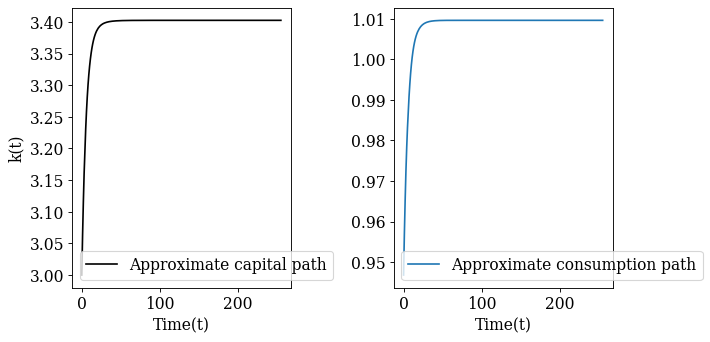

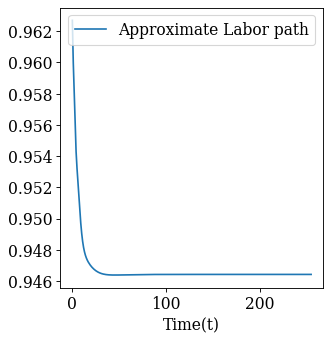

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 960x360 with 0 Axes>

In [103]:
plt.subplot(1, 3, 1)


plt.plot(time_test,k_hat_path, color='k',  label = r"Approximate capital path")
#plt.axhline(y=SS().k_ss, linestyle='--',color='k', label="k Steady State")
plt.ylabel(r"k(t)")
plt.xlabel(r"Time(t)")
#plt.ylim([Params().k_0-0.1,SS().k_ss+0.1 ])
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.plot(time_test,c_hat_path,label= r"Approximate consumption path")
#plt.axhline(y=SS().c_ss, linestyle='--',label="c Steady State")
plt.xlabel(r"Time(t)")
#plt.ylim([c_hat_path[0]-0.1,SS().k_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.subplot(1, 3, 3)
plt.plot(time_test,l_hat_path,label= r"Approximate Labor path")
#plt.axhline(y=SS().l_ss, linestyle='--',label="l Steady State")
plt.xlabel(r"Time(t)")
#plt.ylim([l_hat_path[0]-0.1,SS().k_ss+0.1 ])
plt.tight_layout()
plt.legend(loc='best')
plt.tight_layout()
plt.show()
plt.savefig('my_plot.eps', format='eps')
files.download('my_plot.eps')

<ipython-input-82-eeb629539519>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_test = torch.tensor(productivity_states).unsqueeze(1)  # Productivity states


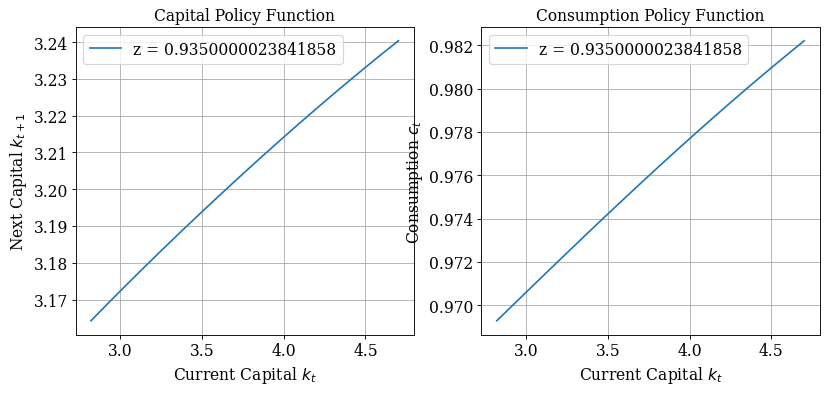

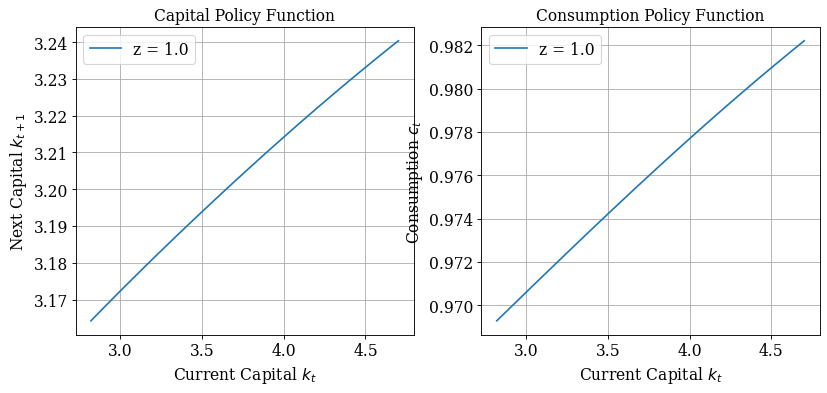

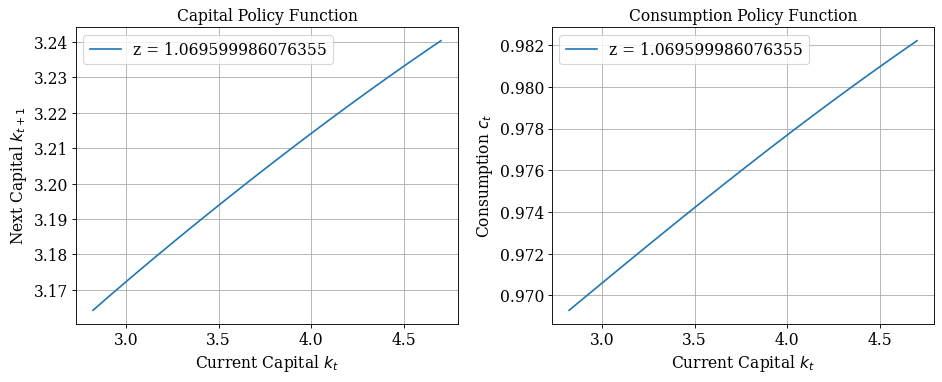

In [ ]:
# Generate test grid for capital and productivity states
k_test = torch.linspace(0.75*SS().k_ss, 1.25*SS().k_ss, 100).unsqueeze(1)  # Capital values
z_test = torch.tensor(productivity_states).unsqueeze(1)  # Productivity states

# Compute policy functions for each state
for z_val in productivity_states:
    z_tensor = torch.full_like(k_test, z_val)  # Fixed z value
    #inputs = torch.cat((k_test), dim=1)  # Combine k and z
    inputs = k_test
    outputs = q_hat(inputs).detach()  # Predicted outputs
    c_policy = outputs[:, 0]  # Predicted consumption
    k_policy = outputs[:, 1]  # Predicted next-period capital

    # Plot the policy functions
    plt.figure(figsize=(12, 5))

    # Capital Policy Function
    plt.subplot(1, 2, 1)
    plt.plot(k_test, k_policy, label=f"z = {z_val}")
    plt.xlabel(r"Current Capital $k_t$")
    plt.ylabel(r"Next Capital $k_{t+1}$")
    plt.title("Capital Policy Function")
    plt.grid(True)
    plt.legend()

    # Consumption Policy Function
    plt.subplot(1, 2, 2)
    plt.plot(k_test, c_policy, label=f"z = {z_val}")
    plt.xlabel(r"Current Capital $k_t$")
    plt.ylabel(r"Consumption $c_t$")
    plt.title("Consumption Policy Function")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
